# Notebook Vizualising Sample Results of Few Methods Avaliable in Nevergrad

In [1]:
from brian2 import *
from brian2tools import *
from nevergrad.optimization import optimizerlib
from nevergrad import instrumentation as inst

In [2]:
%matplotlib inline
prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!
candidates, parameters = [], []

## Setup Model to be Fit

### Parameters

In [3]:
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

### Generate a step-current input and an "experimental" voltage trace

In [4]:
dt = 0.01*ms
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA

N, n1 = np.array([input_current]).shape
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
          'g_na': float(100*msiemens*cm**-2 * area),
          'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt
I = TimedArray(input_current, dt=dt)

### The model

In [5]:
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params_correct, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV
voltage += np.random.randn(len(voltage))

inp_trace = np.array([input_current])

n0, n1 = inp_trace.shape
out_trace = np.array([voltage[:n1]])

## Setup Model for Modelfitting

### Model for modelfitting

In [6]:
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''',
Cm = 1*ufarad*cm**-2 * area, El = -65*mV, EK = -90*mV, ENa = 50*mV, VT = -63*mV)

### setup the nevergrad optimizer

In [7]:
arg1 = inst.var.Array(1).bounded(1e-7*siemens*cm**-2 * area, 1e-4*siemens*cm**-2 * area).asscalar()
arg2 = inst.var.Array(1).bounded(1*msiemens*cm**-2 * area, 200*msiemens*cm**-2 * area).asscalar()
arg3 = inst.var.Array(1).bounded(1*msiemens*cm**-2 * area, 100*msiemens*cm**-2 * area).asscalar()
instrum = inst.Instrumentation(arg1, arg2, arg3)
optim = optimizerlib.registry['StupidRandom'](instrumentation=instrum, num_workers=100)

### Get Parameters From Ask

In [8]:
for _ in range(20):
    cand = optim.ask()
    candidates.append(cand)
    parameters.append(list(cand.args))

In [9]:
parameters

[[7.435565603108107e-09, 3.180327560837526e-05, 9.373698123307407e-06],
 [1.738764705269339e-08, 2.5179770569909036e-05, 1.6451130458386555e-05],
 [8.753679205829414e-09, 3.157936676054254e-05, 1.5229317200064273e-05],
 [1.0010604182458691e-08, 1.3792635510879231e-05, 9.550861244407734e-06],
 [9.960264490138792e-09, 2.045972541710219e-05, 1.3373019634000911e-05],
 [8.404493227629548e-09, 3.412523650009505e-05, 1.5020758781086874e-05],
 [1.2389923464517665e-08, 3.479735020515325e-05, 9.22486788032825e-06],
 [1.2072113789902406e-08, 1.8090311712993658e-05, 1.642183849586058e-05],
 [8.96975943370456e-09, 3.278932080705905e-05, 1.7315634311845934e-05],
 [5.830552823221884e-09, 2.3960204997495688e-05, 8.430309821762457e-06],
 [5.326791798097464e-09, 2.0808156539605776e-05, 7.016630220772434e-06],
 [3.509432917379677e-09, 2.9046928503270207e-05, 6.9318393442888305e-06],
 [1.0579054542177795e-08, 2.63877981370971e-05, 5.292237020887113e-06],
 [1.117138695033368e-08, 6.0479042695660275e-06, 1.

### pass parameters to the NeuronGroup

In [10]:
errors = fit_traces_ask_tell(model = eqs, input_var = 'I', output_var = 'v',\
        input = inp_trace * nA, output = out_trace*mV, dt = dt,
        gl = [1e-5*siemens*cm**-2 * area, 1e-6*siemens*cm**-2 * area],
        g_na = [1*msiemens*cm**-2 * area, 2000*msiemens*cm**-2 * area],
        g_kd = [1*msiemens*cm**-2 * area, 1000*msiemens*cm**-2 * area],
        update=parameters)

INFO       No numerical integration method specified, using method 'exponential_euler' (took 0.20s, trying other methods took 0.11s). [brian2.stateupdaters.base.method_choice]


### give information to the optimizer

In [11]:
for i, candidate in enumerate(candidates):
    value = errors[i]
    optim.tell(candidate, value)

    print(candidate, value)

Candidate(args=(7.435565603108107e-09, 3.180327560837526e-05, 9.373698123307407e-06), kwargs={}) 0.0047472470944623125
Candidate(args=(1.738764705269339e-08, 2.5179770569909036e-05, 1.6451130458386555e-05), kwargs={}) 0.004743009755154249
Candidate(args=(8.753679205829414e-09, 3.157936676054254e-05, 1.5229317200064273e-05), kwargs={}) 0.0047466856344994274
Candidate(args=(1.0010604182458691e-08, 1.3792635510879231e-05, 9.550861244407734e-06), kwargs={}) 0.004746150306893136
Candidate(args=(9.960264490138792e-09, 2.045972541710219e-05, 1.3373019634000911e-05), kwargs={}) 0.004746171745410953
Candidate(args=(8.404493227629548e-09, 3.412523650009505e-05, 1.5020758781086874e-05), kwargs={}) 0.004746834365602956
Candidate(args=(1.2389923464517665e-08, 3.479735020515325e-05, 9.22486788032825e-06), kwargs={}) 0.004745137132043103
Candidate(args=(1.2072113789902406e-08, 1.8090311712993658e-05, 1.642183849586058e-05), kwargs={}) 0.0047452724496235815
Candidate(args=(8.96975943370456e-09, 3.2789

### Get The Best Results

In [12]:
ans = optim.provide_recommendation()
print('correct:', params_correct, '\n output:', ans.args)

correct: {'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06} 
 output: (1.122814453903174e-08, 1.5224708498938615e-05, 5.492448068735659e-06)


## Visualization of the results

In [13]:
params = {'gl': ans.args[0],
          'g_na': ans.args[1],
          'g_kd': ans.args[2]}

### re-run the neuron with new params

In [14]:
start_scope()
G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El
G.set_states(params, units=False)
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage1 = mon.v[0]/mV

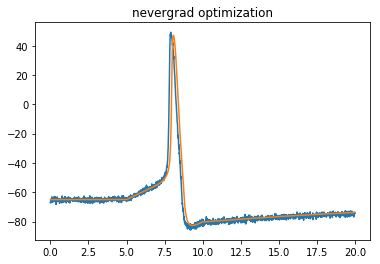

In [15]:
plt.figure()
plot(np.arange(len(voltage))*dt/ms, voltage);
plot(np.arange(len(voltage1))*dt/ms, voltage1);
plt.title('nevergrad optimization');